# Drive

In [37]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [38]:
%cd /gdrive/MyDrive/ANDL/Homework_2

/gdrive/MyDrive/ANDL/Homework_2


# Libraries

In [39]:
!pip install keras_self_attention


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [41]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Load Data

In [42]:
X_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")

X_train.shape, y_train.shape

((2429, 36, 6), (2429,))

In [43]:
# Building our data frame 
df = pd.DataFrame()

for i in range(0, 36):
  temp_df = pd.DataFrame(X_train[:, i, :])
  temp_df["user_id"] = i
  temp_df["label"] = y_train
  df = pd.concat([df, temp_df])
df = df.rename(columns={0:"ch_0", 1:"ch_1", 2:"ch_2", 3:"ch_3", 4:"ch_4", 5:"ch_5", })

print(df)

          ch_0       ch_1       ch_2     ch_3     ch_4      ch_5  user_id  \
0     17.59700    8.17130    -1.7842 -19.7060  -9.7135 -61.88700        0   
1      2.42090   -0.56039    23.6540  -3.8171   1.3721   8.25100        0   
2     39.68800  701.29000  3003.8000  34.8060  65.0360  77.80800        0   
3      1.65540   -1.94840    14.9890  -4.5047  -1.9535  16.39700        0   
4    -15.13900    5.36330     9.6577  -4.3281  -5.4659  22.60500        0   
...        ...        ...        ...      ...      ...       ...      ...   
2424 -16.19600    7.45680    19.1400  21.0160  31.0340  78.30600       35   
2425   4.62530    1.02300     4.1203   2.5242  30.1710  30.37800       35   
2426  -0.72203    2.86720     6.6811  13.4400  17.8740  27.19300       35   
2427   5.93960    2.38200    13.2110  18.6030  33.1230   0.44679       35   
2428  -1.55450   -1.21210     1.0705   1.3272   2.4010   8.45500       35   

      label  
0         0  
1         0  
2         0  
3         0  
4    

In [7]:
y = pd.DataFrame()
y['label'] = df['label'].values
y['user_id'] = df['user_id'].values
print(y)

       label  user_id
0          0        0
1          0        0
2          0        0
3          0        0
4          0        0
...      ...      ...
87439     11       35
87440     11       35
87441     11       35
87442     11       35
87443     11       35

[87444 rows x 2 columns]


In [8]:
del df['label']
# Add a date to use the seasonal_decompose module which requires a date for the points
df['date'] = pd.date_range(start='1/1/1900', periods=len(df), freq='D')
# Convert daily column from just string to DateTime
df['date'] = pd.to_datetime(df['date'])
# Set the column 'Date' as index 
df = df.set_index('date')
# Specify datetime frequency
df = df.asfreq('D')
print(df.shape)
df.head()

(87444, 7)


,ch_0,ch_1,ch_2,ch_3,ch_4,ch_5,user_id
date,,,,,,,
1900-01-01,17.5970,8.17130,-1.7842,-19.7060,-9.7135,-61.887,0
1900-01-02,2.4209,-0.56039,23.6540,-3.8171,1.3721,8.251,0
1900-01-03,39.6880,701.29000,3003.8000,34.8060,65.0360,77.808,0
1900-01-04,1.6554,-1.94840,14.9890,-4.5047,-1.9535,16.397,0
1900-01-05,-15.1390,5.36330,9.6577,-4.3281,-5.4659,22.605,0


In [9]:
X_train_raw = df[df['user_id'] <= 30]
y_train_raw = y[y['user_id'] <= 30]

X_test_raw = df[df['user_id'] > 30]
y_test_raw = y[y['user_id'] > 30]

In [10]:
# Apply MinMaxScaler to the useful features
scale_columns = ['ch_0', 'ch_1', 'ch_2', 'ch_3', 'ch_4', 'ch_5']
scaler = StandardScaler()
scaler = scaler.fit(X_train_raw[scale_columns])

X_train_raw.loc[:, scale_columns] = scaler.transform(X_train_raw[scale_columns].to_numpy())
X_test_raw.loc[:, scale_columns] = scaler.transform(X_test_raw[scale_columns].to_numpy())

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [11]:
# Decompose signal in trand+seasonality+noise

from statsmodels.tsa.seasonal import seasonal_decompose

df_trend = X_train_raw.apply(lambda x: seasonal_decompose(x, model='additive').trend)
df_seasonal = X_train_raw.apply(lambda x: seasonal_decompose(x, model='additive').seasonal)
df_residual = X_train_raw.apply(lambda x: seasonal_decompose(x, model='additive').resid)


In [12]:
df_trend = df_trend.fillna(0)
df_trend.head()

,ch_0,ch_1,ch_2,ch_3,ch_4,ch_5,user_id
date,,,,,,,
1900-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1900-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1900-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1900-01-04,0.004325,0.108637,0.601841,-0.044812,-0.034816,-0.017019,0.0
1900-01-05,0.003002,0.109303,0.603069,-0.039557,-0.034809,0.005761,0.0


In [ ]:
df_seasonal.head()

,ch_0,ch_1,ch_2,ch_3,ch_4,ch_5,user_id
date,,,,,,,
1900-01-01,-0.008107,-0.038023,-0.015788,-0.030176,-0.022690,-0.026800,1.195346e-03
1900-01-02,0.001868,0.012099,0.001574,0.011187,0.000647,0.027486,7.968974e-04
1900-01-03,0.014076,-0.030555,-0.020256,-0.030312,-0.017855,-0.020274,3.984487e-04
1900-01-04,-0.001691,0.005558,-0.013261,-0.017366,-0.014095,-0.029085,-1.039235e-19
1900-01-05,0.051573,0.042341,0.085981,0.113822,0.099754,0.097561,-3.984487e-04


In [13]:
X_train_raw = df_seasonal+df_trend

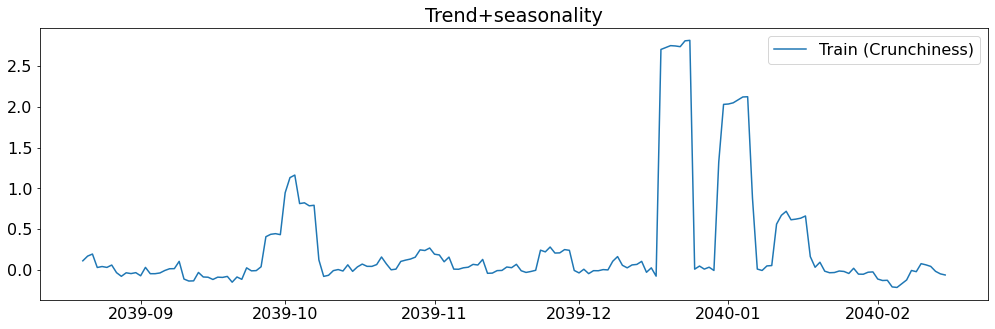

In [14]:
plt.figure(figsize=(17,5))
plt.plot(X_train_raw.ch_0[51000:51180], label='Train (Crunchiness)')
plt.title('Trend+seasonality')
plt.legend()
plt.show()

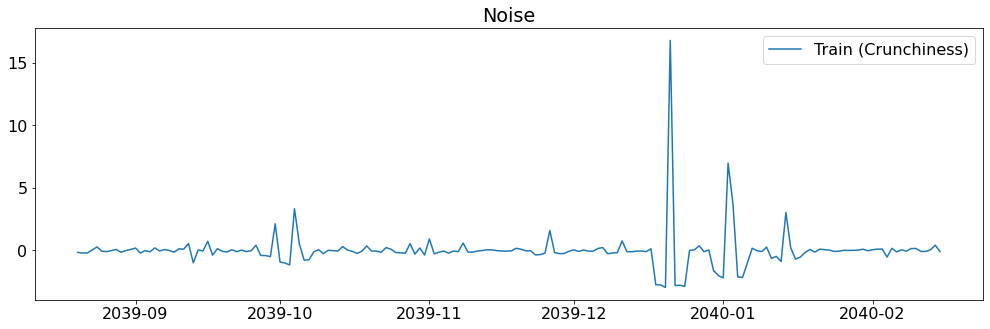

In [15]:
plt.figure(figsize=(17,5))
plt.plot(df_residual.ch_0[51000:51180], label='Train (Crunchiness)')
plt.title('Noise')
plt.legend()
plt.show()

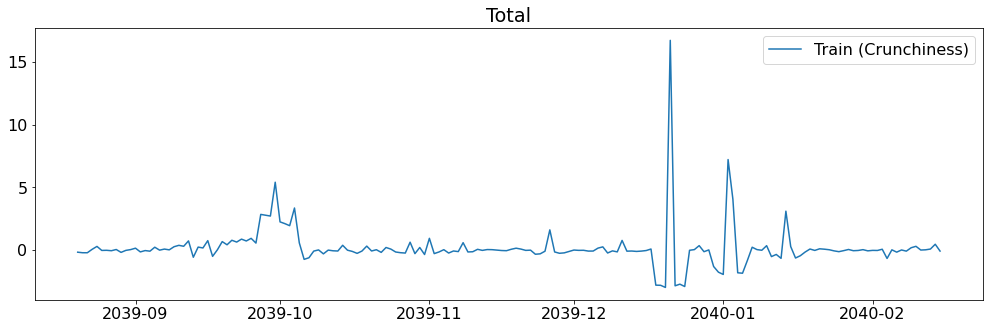

In [16]:
# Trend+Seasonality+Noise
plt.figure(figsize=(17,5))
plt.plot(df_residual.ch_0[51000:51180]+X_train_raw.ch_2[51000:51180], label='Train (Crunchiness)')
plt.title('Total')
plt.legend()
plt.show()

In [17]:
window = 36
stride = 9

In [18]:
def build_sequences(df, window=36, stride=6):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    for l in df['label'].unique():
        # Take only meaningful features
        temp = df[df['label'] == l][['ch_0', 'ch_1', 'ch_2', 'ch_3', 'ch_4', 'ch_5']].values
        # Save the label
        label = df[df['label'] == l]['label'].values[0]
        # Compute padding length
        padding_len = window - len(temp)%window
        # Create padding and concatenate it
        padding = np.zeros((padding_len,6), dtype='float64')
        temp = np.concatenate((temp,padding))
        # Build features windows with their corresponging labels
        idx = 0
        while idx+window <= len(temp):
            dataset.append(temp[idx:idx+window])
            labels.append(label)
            idx += stride
    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [19]:
df_train = X_train_raw
df_train['label'] = y_train_raw['label'].values 

print(df_train)

                ch_0      ch_1      ch_2      ch_3      ch_4      ch_5  \
date                                                                     
1900-01-01 -0.008107 -0.038023 -0.015788 -0.030176 -0.022690 -0.026800   
1900-01-02  0.001868  0.012099  0.001574  0.011187  0.000647  0.027486   
1900-01-03  0.014076 -0.030555 -0.020256 -0.030312 -0.017855 -0.020274   
1900-01-04  0.002634  0.114196  0.588580 -0.062178 -0.048912 -0.046104   
1900-01-05  0.054574  0.151644  0.689050  0.074265  0.064945  0.103322   
...              ...       ...       ...       ...       ...       ...   
2106-02-24  0.014622 -0.024222 -0.000744  0.047923  0.049793  0.020393   
2106-02-25 -0.002249  0.012018  0.006567  0.061119  0.055265  0.011673   
2106-02-26  0.051573  0.042341  0.085981  0.113822  0.099754  0.097561   
2106-02-27 -0.026209  0.000078 -0.020548 -0.036487 -0.032488 -0.037471   
2106-02-28 -0.031511  0.008502 -0.017701 -0.010669 -0.013273 -0.011418   

                 user_id  label  
dat

In [20]:
df_test = X_test_raw
df_test['label'] = y_test_raw['label'].values 

print(df_test)

                ch_0      ch_1      ch_2      ch_3      ch_4      ch_5  \
date                                                                     
2106-03-01  0.431165  0.557220  0.258059 -0.265493  0.596068 -0.128239   
2106-03-02 -0.116319 -0.026826 -0.036591 -0.051510 -0.036322 -0.043903   
2106-03-03  0.081486 -0.007230 -0.044215 -0.058914 -0.015011 -0.114555   
2106-03-04 -0.029480 -0.024907 -0.049892 -0.052665 -0.041341  0.042005   
2106-03-05 -0.095886  0.104205  0.122937  0.696743 -0.075273 -0.624011   
...              ...       ...       ...       ...       ...       ...   
2139-05-27 -0.128938 -0.013552 -0.009475 -0.015349  0.000278  0.070124   
2139-05-28 -0.021831 -0.021929 -0.031599 -0.043680 -0.001111  0.001838   
2139-05-29 -0.049338 -0.019528 -0.027827 -0.026956 -0.020914 -0.002699   
2139-05-30 -0.015070 -0.020160 -0.018208 -0.019046  0.003642 -0.040806   
2139-05-31 -0.053620 -0.024839 -0.036092 -0.045514 -0.045832 -0.029396   

            user_id  label  
date    

<ipython-input-20-7c9ab10b2597>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['label'] = y_test_raw['label'].values


In [21]:
X_train, y_train = build_sequences(df_train, window, stride)
X_test, y_test = build_sequences(df_test, window, stride)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8356, 36, 6), (8356,), (1336, 36, 6), (1336,))

In [22]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8356, 36, 6), (8356, 12), (1336, 36, 6), (1336, 12))

In [23]:
input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200

In [30]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    lstm = tfkl.MaxPool1D()(lstm)
    lstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(lstm)

    attention = SeqSelfAttention(attention_activation='sigmoid')(lstm)
    
    lstm = tfkl.GlobalAveragePooling1D()(attention)
    dropout = tfkl.Dropout(.4)(lstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [31]:
model = build_BiLSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 36, 256)          138240    
 nal)                                                            
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 18, 256)          0         
 1D)                                                             
                                                                 
 bidirectional_3 (Bidirectio  (None, 18, 256)          394240    
 nal)                                                            
                                                                 
 seq_self_attention_1 (SeqSe  (None, 18, 256)          16449     
 lfAttention)                                                

In [33]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
59/59 [==============================] - 36s 462ms/step - loss: 1.7745 - accuracy: 0.3923 - val_loss: 3.1694 - val_accuracy: 0.4234 - lr: 0.0010
Epoch 2/200
59/59 [==============================] - 33s 560ms/step - loss: 1.2896 - accuracy: 0.5090 - val_loss: 3.8977 - val_accuracy: 0.3337 - lr: 0.0010
Epoch 3/200
59/59 [==============================] - 31s 513ms/step - loss: 1.1441 - accuracy: 0.5721 - val_loss: 4.5946 - val_accuracy: 0.4067 - lr: 0.0010
Epoch 4/200
59/59 [==============================] - 30s 512ms/step - loss: 1.0168 - accuracy: 0.6266 - val_loss: 5.3557 - val_accuracy: 0.3409 - lr: 0.0010
Epoch 5/200
59/59 [==============================] - 25s 422ms/step - loss: 0.9246 - accuracy: 0.6674 - val_loss: 5.6838 - val_accuracy: 0.3612 - lr: 0.0010
Epoch 6/200
59/59 [==============================] - 25s 432ms/step - loss: 0.8667 - accuracy: 0.6884 - val_loss: 5.8337 - val_accuracy: 0.3923 - lr: 0.0010
Epoch 7/200
59/59 [==============================] - 25s 4

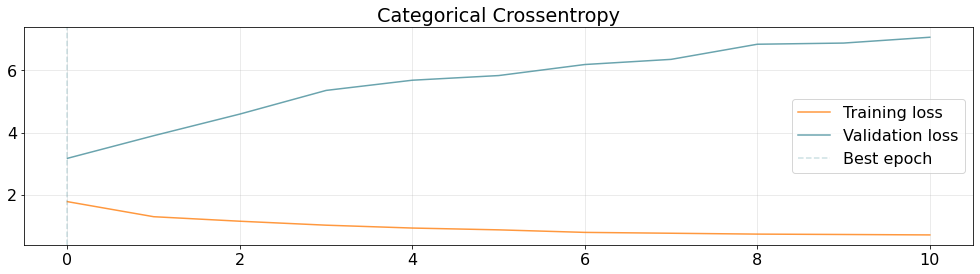

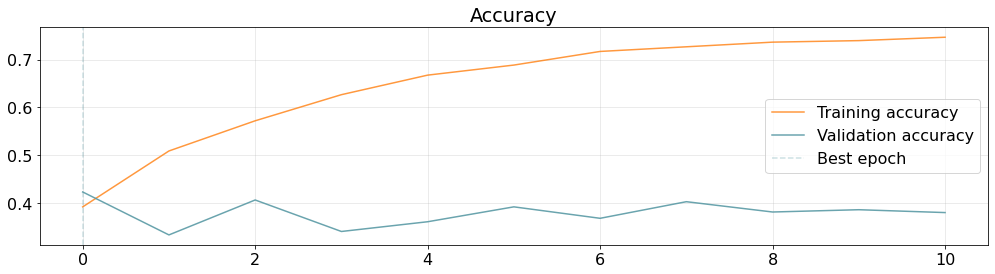

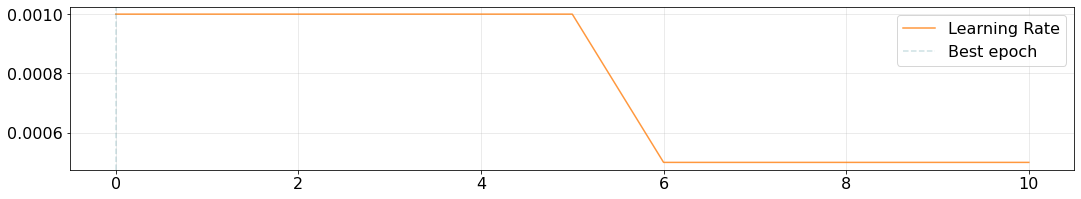

In [34]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# model.save('BiLSTM/attention_v1')
# model = tfk.models.load_model('BiLSTM')

In [35]:
# Predict the test set with the BiLSTM
predictions = model.predict(X_test)
predictions.shape

42/42 [==============================] - 5s 65ms/step


(1336, 12)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5007
Precision: 0.2732
Recall: 0.3056
F1: 0.2569


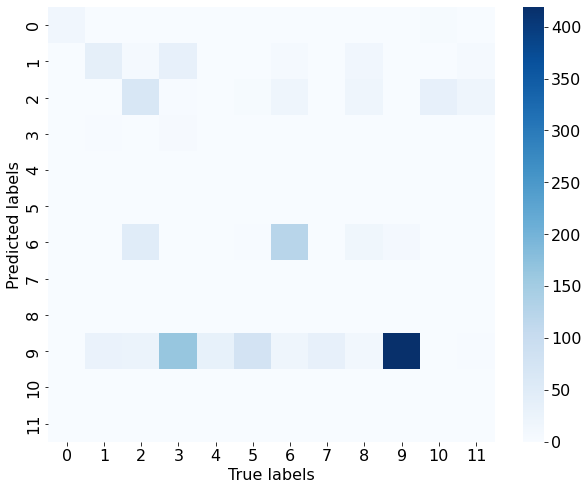

In [36]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list([0,1,2,3,4,5,6,7,8,9,10,11]), yticklabels=list([0,1,2,3,4,5,6,7,8,9,10,11]))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()